In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

In [2]:
P_THRESHOLD=0.5

### read in data

In [3]:
DATADIR = os.getenv('DATADIR')

In [4]:
print("model v2.0.0 was run on data dated {}".format(DATADIR))

model v2.0.0 was run on data dated /data/2018-03-22


In [5]:
labelled_level2 = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level2.csv.gz'),
    dtype=object,
    compression='gzip'
)# Create World taxon in case any items not identified 
# through doc type in clean_content are still present
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

# creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

# Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

# create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labelled_level2['level2taxon_code']),
                        labelled_level2['level2taxon']))

In [6]:
labelled_level2.taxon_id.nunique()

2725

In [9]:
new_pred = pd.read_csv(
    os.path.join(DATADIR, 'level1_predictions_1226_2203_.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [10]:
new_content = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level1.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [11]:
new_content.shape

(17937, 32)

In [12]:
new_arrays = np.load(os.path.join(DATADIR, 'level1_arrays.npz'))

In [13]:
new_arrays.files

['x', 'meta', 'title', 'desc', 'content_id']

In [14]:
new_arrays['content_id'].shape

(17937,)

### combine data

In [21]:
if new_arrays['content_id'].shape[0] == new_pred.shape[0]:
    new_pred['content_id'] = new_arrays['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")
    
    

In [22]:
new_pred['content_id'].nunique()

17012

In [23]:
newprob_by_id = pd.melt(new_pred, 
                        id_vars=['content_id'], var_name='taxon2', value_name='prob')

In [24]:
newprob_by_id.shape

(3892329, 3)

In [25]:
#convert from string to numeric
newprob_by_id['prob'] = pd.to_numeric(newprob_by_id['prob'])
newprob_by_id['taxon2'] = pd.to_numeric(newprob_by_id['taxon2'])

In [26]:
#get the label for the level2 taxon code
newprob_by_id['taxon2label'] = newprob_by_id['taxon2'].map(labels_index)

In [27]:
newprob_meta = pd.merge(
    left=newprob_by_id,
    right=new_content,
    on='content_id',
    how='left',
    indicator=True, 
    validate='m:m'
)

In [28]:
newprob_meta.columns

Index(['content_id', 'taxon2', 'prob', 'taxon2label', 'base_path',
       'content_purpose_document_supertype', 'content_purpose_subgroup',
       'content_purpose_supergroup', 'description', 'details', 'document_type',
       'email_document_supertype', 'first_published_at',
       'government_document_supertype', 'locale',
       'navigation_document_supertype', 'public_updated_at', 'publishing_app',
       'publishing_scheduled_at', 'search_user_need_document_supertype',
       'title', 'updated_at', 'user_journey_document_supertype',
       'document_type_gp', 'primary_publishing_organisation', 'body',
       'combined_text', 'taxon_id', 'taxon_base_path', 'taxon_name',
       'level1taxon', 'level2taxon', 'level3taxon', 'level4taxon',
       'level5taxon', '_merge'],
      dtype='object')

#### drop content ids which are really taxons

In [29]:
#drop taxons document type. Why are these here? Shoudl be cleaned in create_new?
newprob_meta = newprob_meta[newprob_meta['document_type']!='taxon']

In [30]:
newprob_meta.shape

(4303761, 36)

In [31]:
newprob_meta.content_id.nunique()

17012

### count content items

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdff9a2898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efe7a561ef0>]], dtype=object)

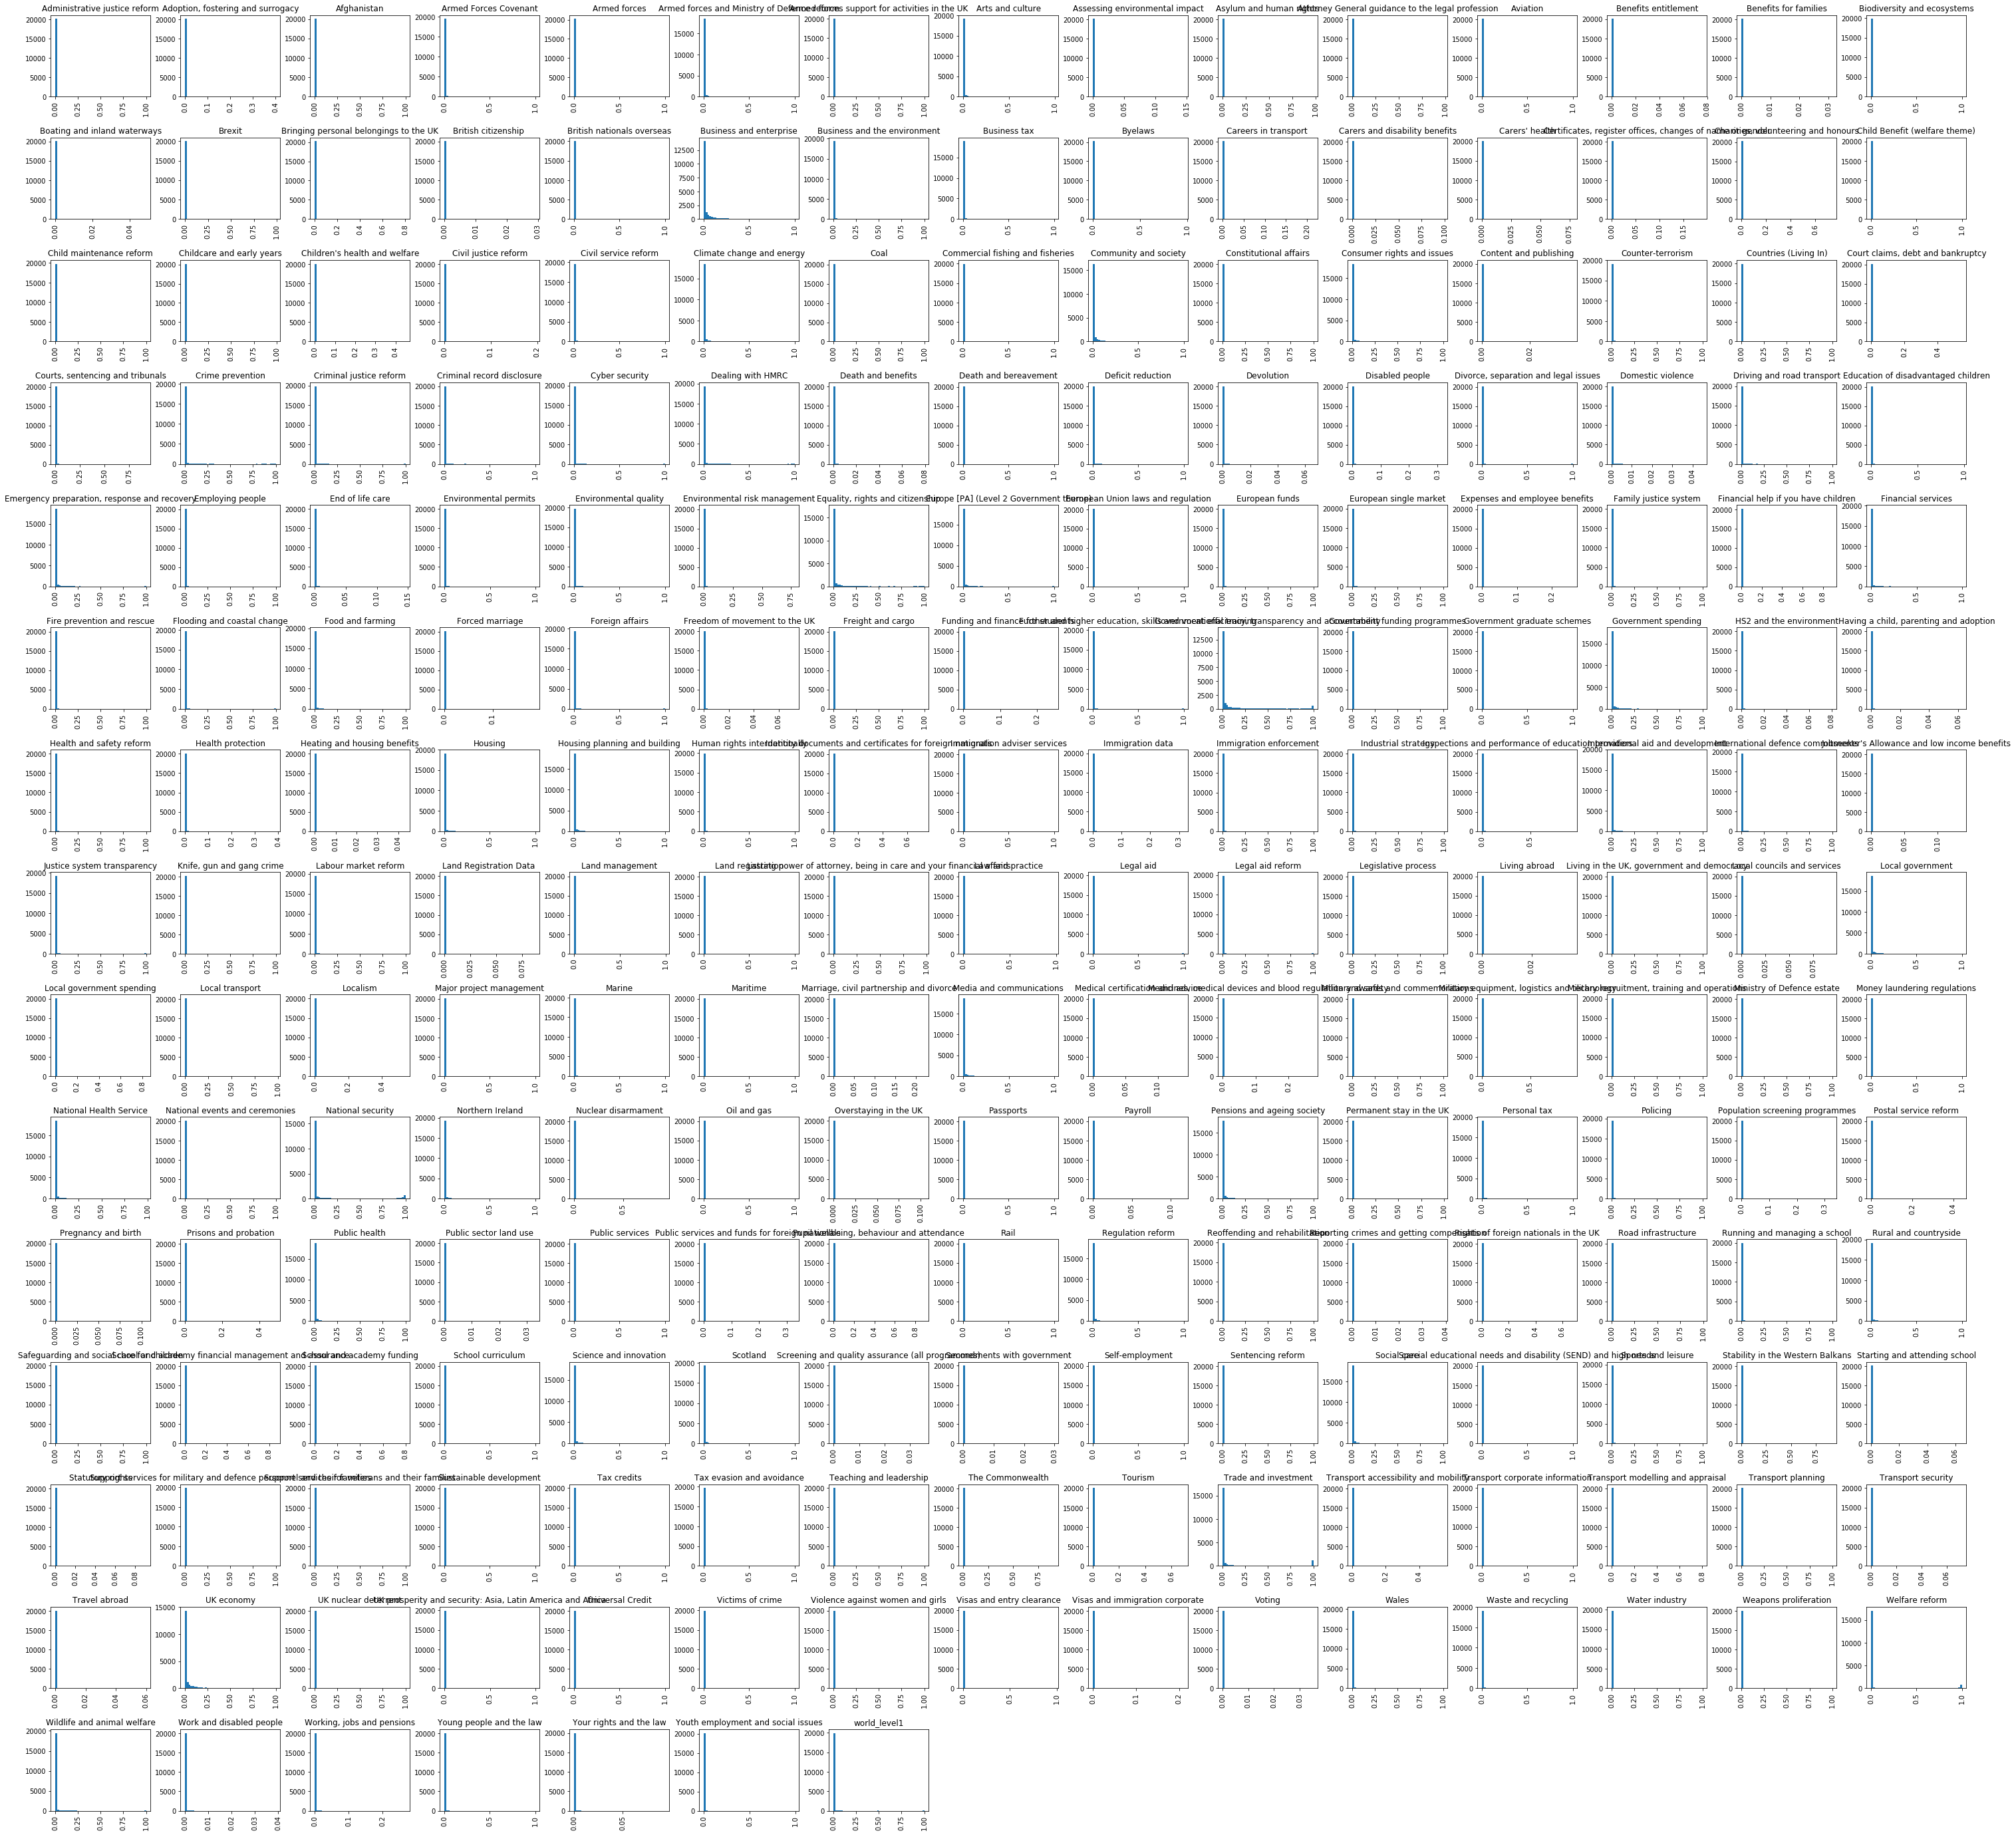

In [62]:
newprob_meta['prob'].hist(by=newprob_meta['taxon2label'], figsize=(50, 50), bins=50)

In [63]:
newprob_meta[newprob_meta['prob']<0.01].shape

(4251937, 36)

In [64]:
newprob_meta[newprob_meta['prob']<0.01].shape[0]/newprob_meta.shape[0]

0.9692891280485928

In [65]:
atleast1pct = newprob_meta[newprob_meta['prob']>=0.01]
atleast1pct.shape

(134718, 36)

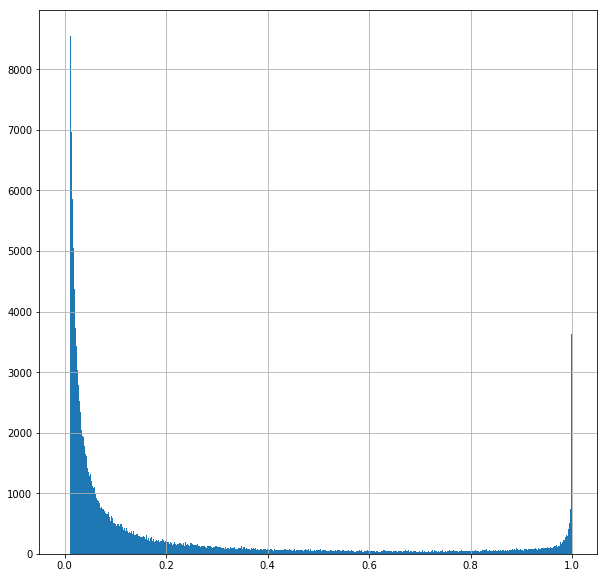

In [66]:
atleast1pct['prob'].hist(range=(0, 1), figsize=(10, 10), bins=500)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe7fc5e630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efe6dc1cb38>]], dtype=object)

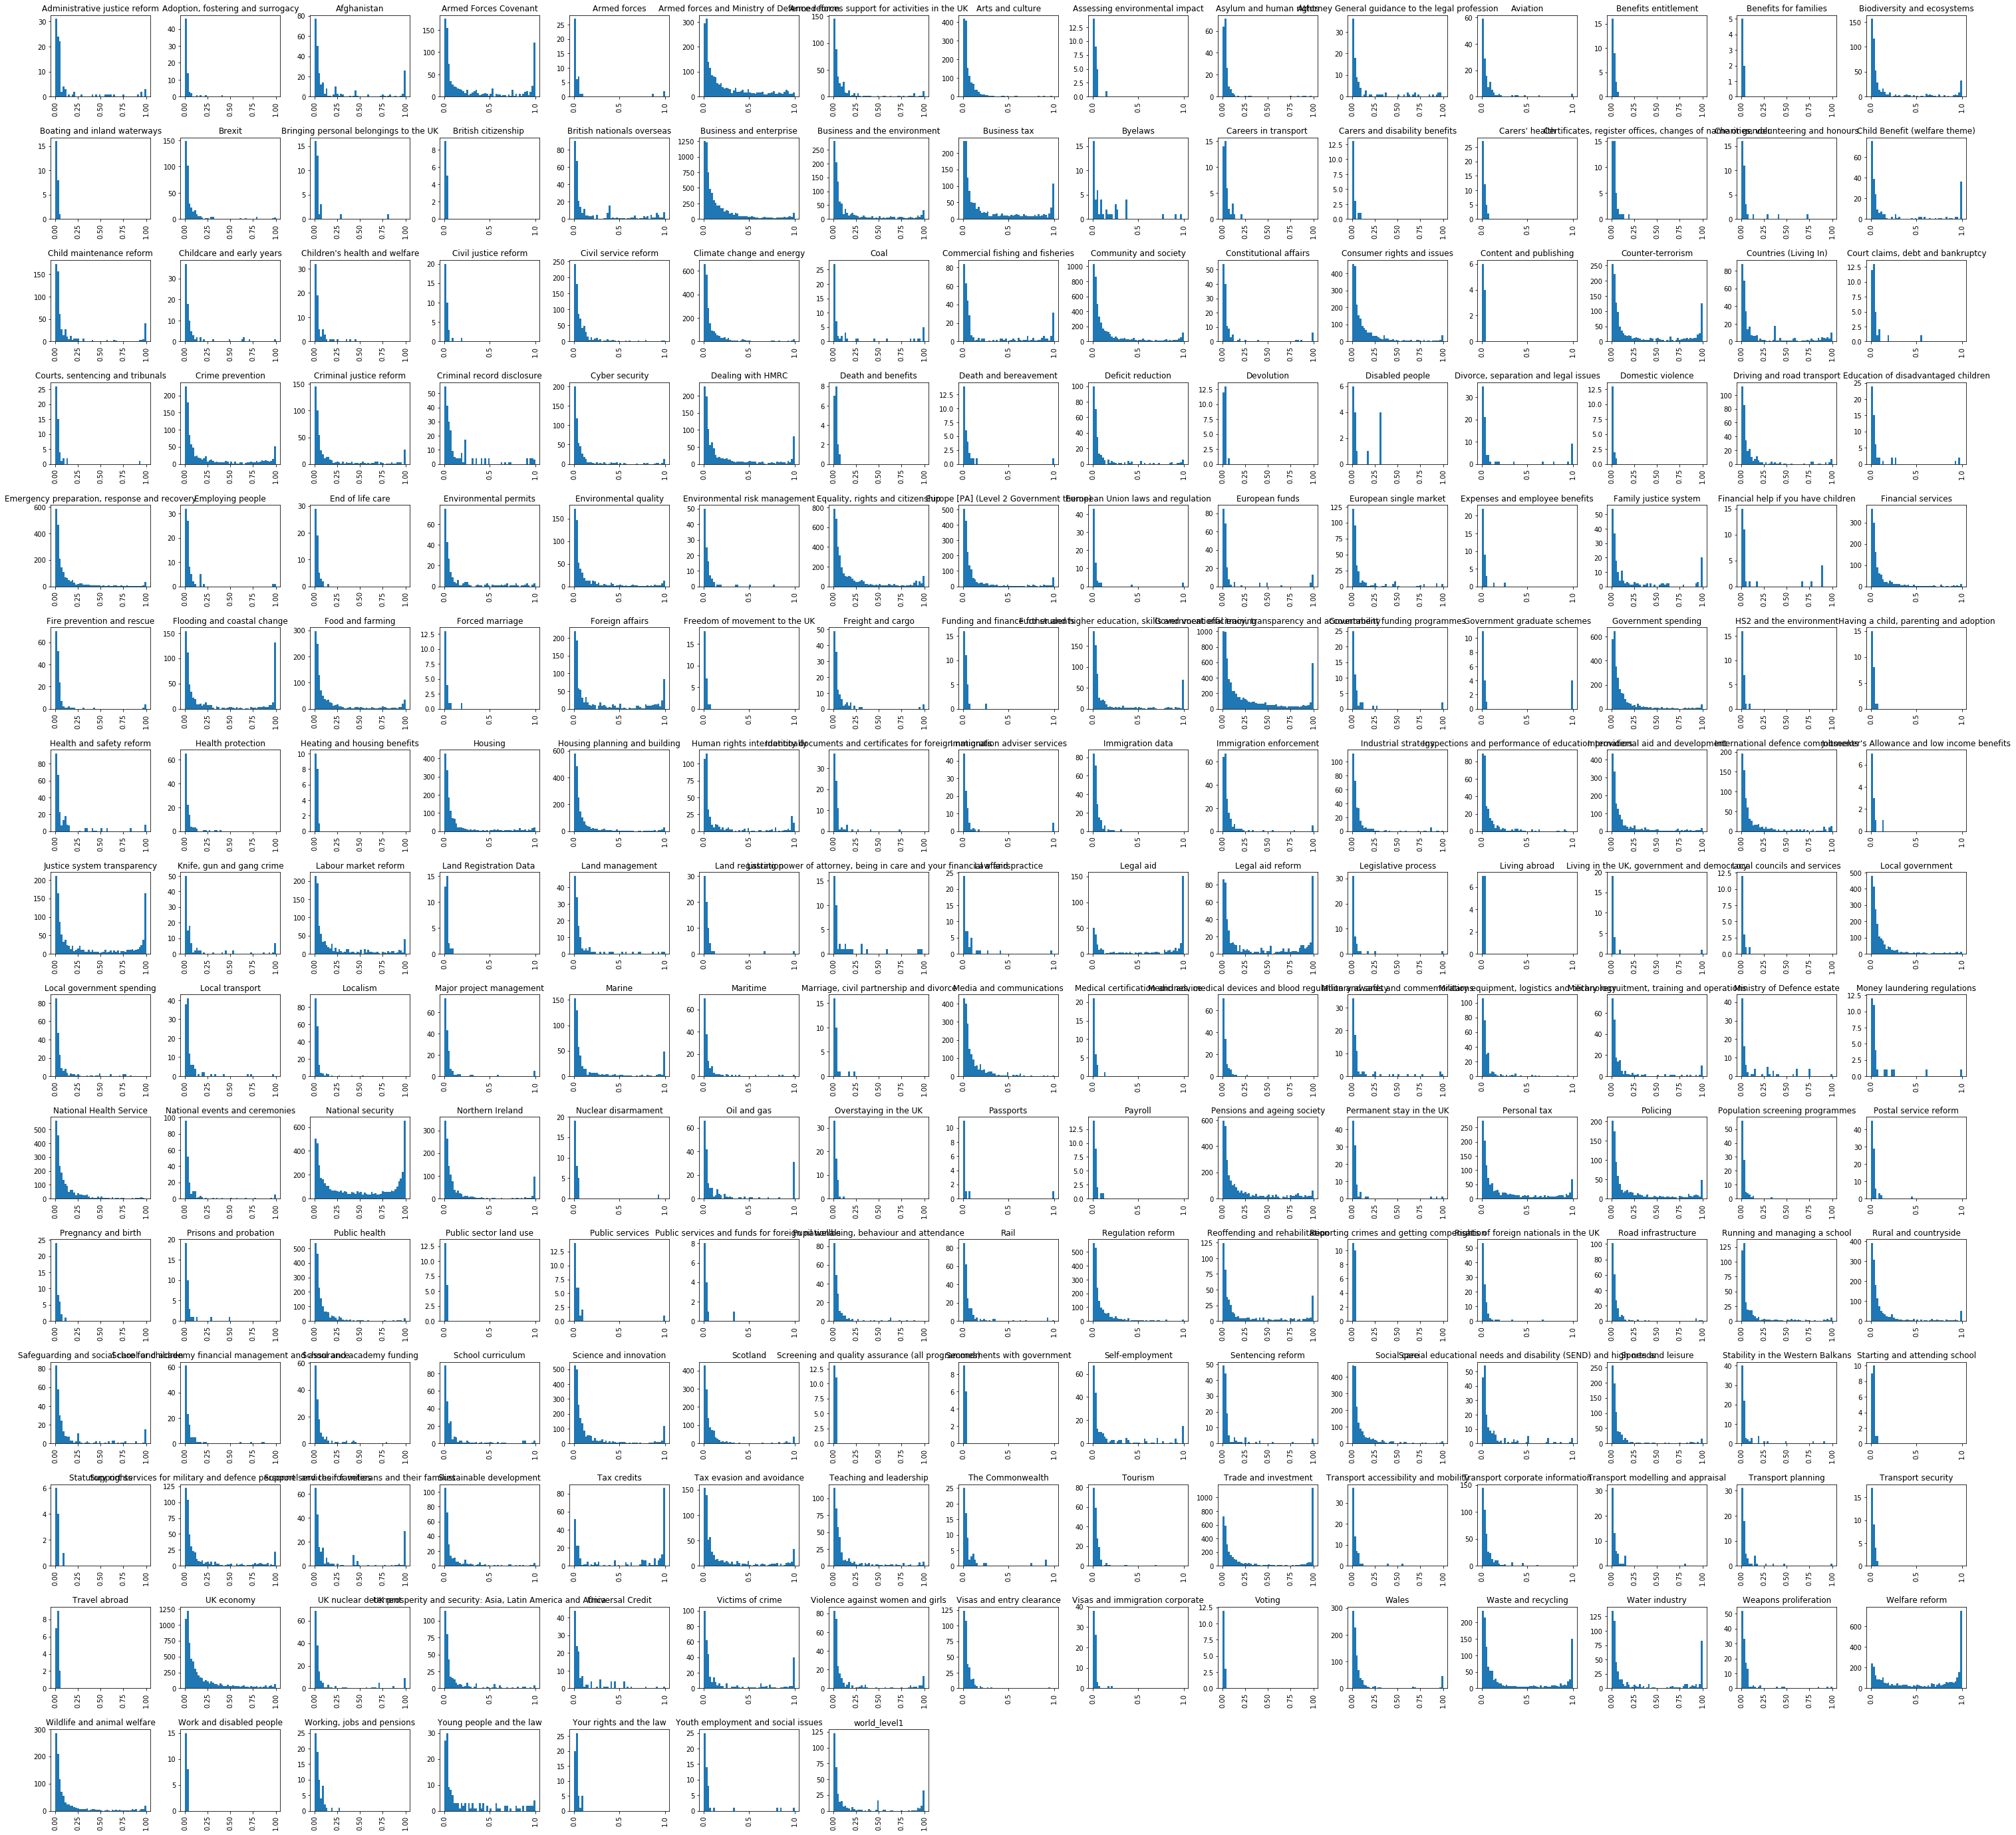

In [67]:
#TODO: work out how to standardise ylim to 0, 3000 
atleast1pct['prob'].hist(by=atleast1pct['taxon2label'], range=(0, 1), figsize=(50, 50), bins=50)

In [68]:
predictions = newprob_meta[newprob_meta['prob'] > 0.5]

In [69]:
predictions['content_id'].nunique()

12735

In [70]:
predictions['content_id'].nunique()/newprob_meta['content_id'].nunique()

0.7351922410807066

In [71]:
predictions.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    12735.000000
mean         1.608009
std          1.352251
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         28.000000
dtype: float64

In [72]:
labelled_level2.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    129137.000000
mean          1.396587
std           0.781779
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          35.000000
dtype: float64

In [73]:
predictions[['prob', 'taxon2label', 'title', 'description', 'level1taxon']][100:150]


,prob,taxon2label,title,description,level1taxon
64355,0.994417,Armed Forces Covenant,uk unites to thank veterans on the 70th annive...,thousands of people have cheered on veterans o...,Defence
64384,0.767802,Armed Forces Covenant,bravery of 3 world war 2 soldiers shot for esc...,a rededication service for these 3 soldiers ha...,Defence
64387,0.982213,Armed Forces Covenant,£5m for scotland’s armed forces community,five scottish charitable projects are set to b...,Defence
64390,0.733989,Armed Forces Covenant,defence secretary: helping our forces get on t...,the government will extend its forces help to ...,Defence
64393,0.999987,Armed Forces Covenant,over 100 opportunities for ex-service personne...,transport for london (tfl) a long time support...,Defence
64394,0.594012,Armed Forces Covenant,100 years on: lest we forget,commemorative events to mark the centenary of ...,Defence
64396,0.891678,Armed Forces Covenant,more flexible compensation for veterans with c...,veterans with mesothelioma can now receive lum...,Defence
64397,0.970583,Armed Forces Covenant,defence minister welcomes london stock exchang...,minister for defence people and veterans tobia...,Defence
64424,0.992054,Armed Forces Covenant,two unknown soldiers from world war 1 honoured...,on 29 september 2016 a burial service was held...,Defence
64431,0.704516,Armed Forces Covenant,minister for armed forces visits future army l...,penny mordaunt visits officer cadets at the ro...,Defence


In [74]:
predictions.to_csv(os.path.join(DATADIR, 'level1_predictions50.csv.gz'),compression='gzip',index=False)

In [93]:
taxons = predictions['taxon2label'].unique()
subsample = pd.DataFrame(columns = predictions.columns)

for taxon in taxons:
    taxon_spec = predictions.loc[predictions['taxon2label']==taxon]
    sample_size = int(round(taxon_spec.shape[0]*0.1))
    if not sample_size == 0 and taxon_spec.shape[0] > sample_size:
        print(taxon,": SAMPLING AT:",sample_size)
        subsample = subsample.append(taxon_spec.sample(n=sample_size), ignore_index=True)

Administrative justice reform : SAMPLING AT: 1
Afghanistan : SAMPLING AT: 4
Armed Forces Covenant : SAMPLING AT: 28
Armed forces and Ministry of Defence reform : SAMPLING AT: 39
Armed forces support for activities in the UK : SAMPLING AT: 3
Arts and culture : SAMPLING AT: 4
Attorney General guidance to the legal profession : SAMPLING AT: 2
Biodiversity and ecosystems : SAMPLING AT: 9
Brexit : SAMPLING AT: 2
British nationals overseas : SAMPLING AT: 6
Business and enterprise : SAMPLING AT: 77
Business and the environment : SAMPLING AT: 19
Business tax : SAMPLING AT: 39
Child Benefit (welfare theme) : SAMPLING AT: 5
Child maintenance reform : SAMPLING AT: 7
Civil service reform : SAMPLING AT: 2
Climate change and energy : SAMPLING AT: 12
Coal : SAMPLING AT: 1
Commercial fishing and fisheries : SAMPLING AT: 9
Community and society : SAMPLING AT: 63
Constitutional affairs : SAMPLING AT: 1
Consumer rights and issues : SAMPLING AT: 17
Counter-terrorism : SAMPLING AT: 35
Countries (Living In)

In [96]:
subsample.columns

Index(['content_id', 'taxon2', 'prob', 'taxon2label', 'base_path',
       'content_purpose_document_supertype', 'content_purpose_subgroup',
       'content_purpose_supergroup', 'description', 'details', 'document_type',
       'email_document_supertype', 'first_published_at',
       'government_document_supertype', 'locale',
       'navigation_document_supertype', 'public_updated_at', 'publishing_app',
       'publishing_scheduled_at', 'search_user_need_document_supertype',
       'title', 'updated_at', 'user_journey_document_supertype',
       'document_type_gp', 'primary_publishing_organisation', 'body',
       'combined_text', 'taxon_id', 'taxon_base_path', 'taxon_name',
       'level1taxon', 'level2taxon', 'level3taxon', 'level4taxon',
       'level5taxon'],
      dtype='object')

In [97]:
subsample[['base_path', 'taxon2label', 'level1taxon','title', 'description']].to_csv(os.path.join(DATADIR, 'level1_predictions_subsample.csv.gz'),compression='gzip',index=False)

### 40% threshold

In [75]:
predictions40 = newprob_meta[newprob_meta['prob'] > 0.4]

predictions40.content_id.nunique()

predictions40.content_id.nunique()/newprob_meta.content_id.nunique()

0.7965592887657315

### HARD to tag

In [76]:
predictions.groupby('_merge').size()

_merge
left_only         0
right_only        0
both          20478
dtype: int64

In [77]:
predictions.drop(labels='_merge', axis=1, inplace=True)

newprob_meta.drop(labels='_merge', axis=1, inplace=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [78]:
no_predictions = pd.merge(
    left=predictions,
    right=newprob_meta,
    on='content_id',
    how='outer',
    indicator=True
)

In [79]:
no_predictions.groupby('_merge').size()

_merge
left_only           0
right_only    1177442
both          7055538
dtype: int64

In [80]:
no_predictions = no_predictions[no_predictions['_merge']=='right_only']

In [81]:
no_predictions.shape

(1177442, 70)

In [82]:
no_predictions.content_id.nunique()

4587

In [83]:
predictions.content_id.nunique()

12735

In [84]:
no_predictions.content_id.nunique() + predictions.content_id.nunique()

17322

In [85]:
newprob_meta.content_id.nunique()

17322

In [86]:
no_predictions = no_predictions[['content_id', 'prob_y', 'taxon2label_y', 'title_y', 'description_y', 'level1taxon_y']].sort_values('prob_y', ascending=False)

In [87]:
no_predictions[(no_predictions['prob_y']<0.5) & (no_predictions['prob_y']>=0.4)].content_id.nunique()

1063

In [88]:
no_predictions[(no_predictions['prob_y']<0.4) & (no_predictions['prob_y']>=0.3)].content_id.nunique()

1371

In [89]:
no_predictions[(no_predictions['prob_y']<0.3) & (no_predictions['prob_y']>=0.2)]['content_id'].nunique()

1916

In [90]:
no_predictions[(no_predictions['prob_y']<0.2) & (no_predictions['prob_y']>=0.1)]['content_id'].nunique()

2643

In [91]:
no_predictions[(no_predictions['prob_y']<0.1) ]['content_id'].nunique()

4587

In [92]:
no_predictions.to_csv(os.path.join(DATADIR, 'level1_hardtotag50.csv.gz'),compression='gzip',index=False)

In [98]:
58385 + 17322

75707